<a href="https://colab.research.google.com/github/B06o/IDoUnderstand/blob/master/translate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi

Tue Jun  8 14:40:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch 
import torchtext

from sklearn.model_selection import train_test_split

import random
import re 
from tqdm import tqdm
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt 
import unicodedata
import datetime
import time
from torchtext.legacy.data import Field, Dataset, Example, Iterator
import copy
import torch.nn as nn 
import matplotlib.pyplot as plt
import os 
import pdb

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device=",device)

device= cuda


In [ ]:
# 这里挂载了我的云硬盘，使用时可自行下载数据集
data_df = pd.read_csv("/content/drive/MyDrive/eng-fra.txt",encoding="utf-8",sep="\t",header=None,names=["eng","fra"],index_col=False)

print(data_df.shape)
print(data_df.values.shape)
print(data_df.values[0])
print(data_df.values[0].shape)
data_df.head()

(135842, 2)
(135842, 2)
['Go.' 'Va !']
(2,)


,eng,fra
0,Go.,Va !
1,Run!,Cours !
2,Run!,Courez !
3,Wow!,Ça alors !
4,Fire!,Au feu !


In [ ]:
# 数据预处理
# 将unicode字符串转化为ASCII码：
def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')


# 规范化字符串
def normalizeString(s):
    # print(s) # list  ['Go.']
    # s = s[0]
    s = s.lower().strip()
    s = unicodeToAscii(s)
    s = re.sub(r"([.!?])", r" \1", s)  # \1表示group(1)即第一个匹配到的 即匹配到'.'或者'!'或者'?'后，一律替换成'空格.'或者'空格!'或者'空格？'
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)  # 非字母以及非.!?的其他任何字符 一律被替换成空格
    s = re.sub(r'[\s]+', " ", s)  # 将出现的多个空格，都使用一个空格代替。例如：w='abc  1   23  1' 处理后：w='abc 1 23 1'
    return s


In [ ]:
print(normalizeString('Va !'))
print(normalizeString('Go.'))

va !
go .


In [ ]:
MAX_LENGTH = 10

eng_prefixes = (  # 之前normalizeString()已经对撇号等进行了过滤，以及清洗，小写化等
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

# print(eng_prefixes)
pairs = [[normalizeString(s) for s in line] for line in data_df.values]


In [ ]:
print('pairs num=', len(pairs))
print(pairs[0])
print(pairs[1])

pairs num= 135842
['go .', 'va !']
['run !', 'cours !']


In [ ]:
# 文件是英译法，我们实现的是法译英，所以进行了reverse，所以pair[1]是英语
# 为了快速训练，仅保留“我是”“你是”“他是”等简单句子，并且删除原始文本长度大于10个标记的样本
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and \
           p[0].startswith(eng_prefixes)  # startswith first arg must be str or a tuple of str


def filterPairs(pairs):
    # 过滤，并交换句子顺序，得到法英句子对（之前是英法句子对）
    return [[pair[1], pair[0]] for pair in pairs if filterPair(pair)]


pairs = filterPairs(pairs)


In [ ]:
# # 留下大于最小长度的序列，在长句子上测试是否可以缺少位置编码
# MIN_LENGTH = 10
# MAX_LENGTH = 18
# def filterPair_min(p):
#     return len(p[0].split(' ')) > MIN_LENGTH and len(p[1].split(' ')) > MIN_LENGTH

# def filterPair_max(p):
#     return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH


# def filterPairs(pairs):
#     # 过滤，并交换句子顺序，得到法英句子对（之前是英法句子对）
#     return [[pair[1], pair[0]] for pair in pairs if filterPair_min(pair) and filterPair_max(pair)]


# pairs = filterPairs(pairs)


In [ ]:
print('after trimming, pairs num=', len(pairs))
print(pairs[0])
print(pairs[1])
print(random.choice(pairs))
print(pairs[0:2])

after trimming, pairs num= 10599
['j ai ans .', 'i m .']
['je vais bien .', 'i m ok .']
['nous sommes pieges !', 'we re trapped !']
[['j ai ans .', 'i m .'], ['je vais bien .', 'i m ok .']]


In [ ]:
# 划分数据集： 训练集和验证集
train_pairs, val_pairs = train_test_split(pairs, test_size=0.2, random_state=1234)

In [ ]:
print(len(train_pairs))
print(len(val_pairs))

8479
2120


In [ ]:
tokenizer = lambda x: x.split()

SRC_TEXT = Field(sequential=True,
tokenize=tokenizer,
# +2 因为<start>和<end>
fix_length=MAX_LENGTH+2,
preprocessing=lambda x:["<start>"] + x + ["<end>"])

TGT_TEXT = Field(sequential=True,
tokenize=tokenizer,
fix_length=MAX_LENGTH+2,
preprocessing=lambda x:["<start>"] + x + ["<end>"])

def get_dataset(pairs, src, tgt):
    # field信息：fields dict([str, Field])
    fields = [("src",src),("tgt",tgt)]
    # list(Example)
    examples = [] 
    for fra, eng in tqdm(pairs):
        # 创建Example时会调用field.preprocessing方法
        examples.append(Example.fromlist([fra,eng],fields))
    return examples, fields


In [ ]:
ds_train = Dataset(*get_dataset(train_pairs, SRC_TEXT, TGT_TEXT))
ds_val = Dataset(*get_dataset(val_pairs, SRC_TEXT, TGT_TEXT))

100%|██████████| 2120/2120 [00:00<00:00, 139957.57it/s]


In [ ]:
print(len(ds_train[0].src), ds_train[0].src)
print(len(ds_train[0].tgt), ds_train[0].tgt)
ds_train.src

9 ['<start>', 'tu', 'n', 'es', 'qu', 'un', 'lache', '.', '<end>']
8 ['<start>', 'you', 're', 'just', 'a', 'coward', '.', '<end>']


<generator object Dataset.__getattr__ at 0x7f82227237d0>

In [ ]:
SRC_TEXT.build_vocab(ds_train)
print(len(SRC_TEXT.vocab))
print(SRC_TEXT.vocab.itos[0])
print(SRC_TEXT.vocab.itos[1])
print(SRC_TEXT.vocab.itos[2])
print(SRC_TEXT.vocab.itos[3])
print(SRC_TEXT.vocab.stoi["<start>"])
print(SRC_TEXT.vocab.stoi["<end>"])

3901
<unk>
<pad>
<end>
<start>
3
2


In [ ]:
# 模拟decode
res = []
for id in [3, 5, 6, 71, 48, 5, 8, 32, 743, 4, 2, 1]:
    res.append(SRC_TEXT.vocab.itos[id])
print(" ".join(res)+"\n")

<start> je suis fais si je vous l examen . <end> <pad>



In [ ]:
TGT_TEXT.build_vocab(ds_train)
print(len(TGT_TEXT.vocab))
print(TGT_TEXT.vocab.itos[0])
print(TGT_TEXT.vocab.itos[1])
print(TGT_TEXT.vocab.itos[2])
print(TGT_TEXT.vocab.itos[3])
print(TGT_TEXT.vocab.stoi['<start>'])
print(TGT_TEXT.vocab.stoi['<end>'])

2591
<unk>
<pad>
<end>
<start>
3
2


In [ ]:
BATCH_SIZE = 64

# 构建数据管道迭代器
# split可以分开处理训练和验证集
# train_iter由许多batch组成
train_iter, val_iter = Iterator.splits(
    (ds_train, ds_val),
    sort_within_batch=True,
    sort_key=lambda x:len(x.src),
    batch_sizes=(BATCH_SIZE, BATCH_SIZE)
)

# 查看数据管道信息，会触发postprocessing，如果有的话
for batch in train_iter:
    # 注意，这里text第一维是seq_len，而非batch
    print(batch.src[:,0])
    print(batch.src.shape, batch.tgt.shape)
    break

tensor([   3,    5,    6,   44,   93,   35, 1508,   10,  393,    4,    2,    1])
torch.Size([12, 64]) torch.Size([12, 64])


将数据管道组织成与torch.utils.data.DataLoader相似的inputs, targets的输出形式：



In [ ]:
class DataLoader:
    def __init__(self, data_iter):
        self.data_iter = data_iter
        self.length = len(data_iter)
    
    def __len__(self):
        return self.length
    
    def __iter__(self):
        # 注意，此处调整text的shape为batch_first
        for batch in self.data_iter:
            yield(torch.transpose(batch.src, 0, 1), torch.transpose(batch.tgt, 0, 1))

train_dataloader = DataLoader(train_iter)
val_dataloader = DataLoader(val_iter)

In [ ]:
# 查看数据管道
print("len(train_dataloader):",len(train_dataloader))
for batch_src, batch_tgt in train_dataloader:
    print(batch_src.shape, batch_tgt.shape)
    print(batch_src[0], batch_src.dtype)
    print(batch_tgt[0], batch_tgt.dtype)
    break

len(train_dataloader): 133
torch.Size([64, 12]) torch.Size([64, 12])
tensor([  3,   5,   6,  69,  10,   8, 529,  48, 329,   4,   2,   1]) torch.int64
tensor([  3,   5,   7,  36,  13, 473,   8,  48, 337,   4,   2,   1]) torch.int64


In [ ]:
# Tensor = torch.Tensor
# # 给一个tensor所有位置的位置编码
# def positional_encoding(X, num_features, dropout_p=0.1, max_len=128) -> Tensor:
#     r'''
#         给输入加入位置编码
#     参数：
#         - num_features: 输入进来的维度
#         - dropout_p: dropout的概率，当其为非零元素时执行dropout
#         - max_len: 句子的最大长度，默认512
    
#     形状：
#         - 输入： [batch_size, seq_length, num_features]
#         - 输出： ([batch_size, seq_length, num_features], [1, max_len, num_features])

#     例子：
#         >>> X = torch.randn((2,4,10))
#         >>> X = positional_encoding(X, 10)
#         >>> print(X.shape)
#         >>> torch.Size([2, 4, 10])
#     '''

#     dropout = nn.Dropout(dropout_p)
#     P = torch.zeros((1,max_len,num_features))
#     X_ = torch.arange(max_len,dtype=torch.float32).reshape(-1,1) / torch.pow(
#         10000,
#         torch.arange(0,num_features,2,dtype=torch.float32) /num_features)
#     P[:,:,0::2] = torch.sin(X_)
#     P[:,:,1::2] = torch.cos(X_)
#     X = X + P[:,:X.shape[1],:].to(X.device)
#     return dropout(X) , P

In [ ]:
## no Dropout
# Tensor = torch.Tensor
# # 给一个tensor所有位置的位置编码
# def positional_encoding(X, num_features, dropout_p=0.0, max_len=128) -> Tensor:
#     r'''
#         给输入加入位置编码
#     参数：
#         - num_features: 输入进来的维度
#         - dropout_p: dropout的概率，当其为非零元素时执行dropout
#         - max_len: 句子的最大长度，默认512
    
#     形状：
#         - 输入： [batch_size, seq_length, num_features]
#         - 输出： [batch_size, seq_length, num_features]

#     例子：
#         >>> X = torch.randn((2,4,10))
#         >>> X = positional_encoding(X, 10)
#         >>> print(X.shape)
#         >>> torch.Size([2, 4, 10])
#     '''

#     dropout = nn.Dropout(dropout_p)
#     P = torch.zeros((1,max_len,num_features))
#     X_ = torch.arange(max_len,dtype=torch.float32).reshape(-1,1) / torch.pow(
#         10000,
#         torch.arange(0,num_features,2,dtype=torch.float32) /num_features)
#     P[:,:,0::2] = torch.sin(X_)
#     P[:,:,1::2] = torch.cos(X_)
#     X = X + P[:,:X.shape[1],:].to(X.device)
#     return dropout(X), P

In [ ]:
# '''
# 400维之后全部重置为0
# '''
# Tensor = torch.Tensor
# # 给一个tensor所有位置的位置编码
# def positional_encoding(X, num_features, dropout_p=0.1, max_len=128) -> Tensor:
#     r'''
#         给输入加入位置编码
#     参数：
#         - num_features: 输入进来的维度
#         - dropout_p: dropout的概率，当其为非零元素时执行dropout
#         - max_len: 句子的最大长度，默认512
    
#     形状：
#         - 输入： [batch_size, seq_length, num_features]
#         - 输出： ([batch_size, seq_length, num_features], [1, max_len, num_features])

#     例子：
#         >>> X = torch.randn((2,4,10))
#         >>> X = positional_encoding(X, 10)
#         >>> print(X.shape)
#         >>> torch.Size([2, 4, 10])
#     '''

#     dropout = nn.Dropout(dropout_p)
#     P = torch.zeros((1,max_len,num_features))
#     X_ = torch.arange(max_len,dtype=torch.float32).reshape(-1,1) / torch.pow(
#         10000,
#         torch.arange(0,num_features,2,dtype=torch.float32) /num_features)
#     P[:,:,0::2] = torch.sin(X_)
#     P[:,:,1::2] = torch.cos(X_)
#     P[:,:,399:] = 0
#     P.requires_grad = False
#     X = X + P[:,:X.shape[1],:].to(X.device)
#     return X , P

In [ ]:
# 只有sin,cos
Tensor = torch.Tensor
# 给一个tensor所有位置的位置编码
def positional_encoding(X, num_features, dropout_p=0.1, max_len=128) -> Tensor:
    r'''
        给输入加入位置编码
    参数：
        - num_features: 输入进来的维度
        - dropout_p: dropout的概率，当其为非零元素时执行dropout
        - max_len: 句子的最大长度，默认512
    
    形状：
        - 输入： [batch_size, seq_length, num_features]
        - 输出： [batch_size, seq_length, num_features]

    例子：
        >>> X = torch.randn((2,4,10))
        >>> X = positional_encoding(X, 10)
        >>> print(X.shape)
        >>> torch.Size([2, 4, 10])
    '''

    dropout = nn.Dropout(dropout_p)
    P = torch.zeros((1,max_len,num_features))
    X_ = torch.arange(max_len,dtype=torch.float32).reshape(-1,1) / torch.pow(
        10000,
        torch.arange(0,num_features,dtype=torch.float32) /num_features)
    P[:,:,0:] = torch.sin(X_)
    X = X + P[:,:X.shape[1],:].to(X.device)
    return dropout(X), P

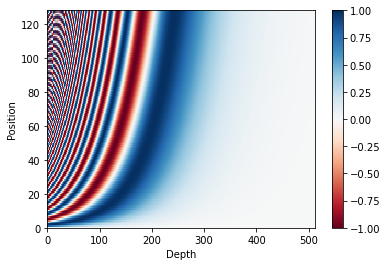

In [ ]:
def draw_pos_encoding(pos_encoding, d_model):
    plt.figure()
    plt.pcolormesh(pos_encoding[0],cmap="RdBu")
    plt.xlabel("Depth")
    plt.xlim((0, d_model))
    plt.ylabel("Position")
    plt.colorbar()
    plt.show()

X = torch.randn((2,4,512))
pos_encoding = positional_encoding(X, 512)
draw_pos_encoding(pos_encoding[1], 512)


In [ ]:
# 在NLP中，<PAD>用以填充句子，而这没有携带任何信息，故需要被mask掉
# 返回True和False组成的mask
def get_attn_pad_mask(seq_q, seq_k):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(1) 即为<PAD>
    # 注意torchtext是<pad>为1而非0
    pad_attn_mask = seq_k.data.eq(1).unsqueeze(1)
    return pad_attn_mask.expand(batch_size, len_q, len_k)

In [ ]:
# 返回1，0组成的mask
def get_attn_subsequent_mask(seq):
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    subsequent_mask = torch.triu(torch.ones(attn_shape),1)
    subsequent_mask = subsequent_mask.byte()
    return subsequent_mask

In [ ]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V, attn_mask):
        # scores : [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) 
        # 1的位置全部填充以忽略
        scores.masked_fill_(attn_mask, -1e9)
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V)
        return context, attn

In [ ]:
w = nn.Linear(128, 10 * 8)
q = torch.randn((10, 10, 128))
# 第一个10不动，(10 x 128) x (128 x 80) => 10 x 80
# 无转置，其实是q x w
w(q).shape

torch.Size([10, 10, 80])

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_k * n_heads)
        self.W_K = nn.Linear(d_model, d_k * n_heads)
        self.W_V = nn.Linear(d_model, d_v * n_heads)
        self.linear = nn.Linear(n_heads * d_v, d_model)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, Q, K, V, attn_mask):
        # Q: [batch_size x len_q x d_model], K: [batch_size x len_k x d_model], V: [batch_size x len_k x d_model]

        residual, batch_size = Q, Q.size(0)
        
        # (B, S, D) -proj-> (B, S, D) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        # q_s: [batch_size x n_heads x len_q x d_k]
        q_s = self.W_Q(Q).view(batch_size, -1, n_heads, d_k).transpose(1,2)
        
        # k_s: [batch_size x n_heads x len_k x d_k]  
        k_s = self.W_K(K).view(batch_size, -1, n_heads, d_k).transpose(1,2)
        
        # v_s: [batch_size x n_heads x len_k x d_v]  
        v_s = self.W_V(V).view(batch_size, -1, n_heads, d_v).transpose(1,2)  
        
        # attn_mask : [batch_size x n_heads x len_q x len_k]
        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1)
        
        # context: [batch_size x n_heads x len_q x d_v]
        # attn: [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        context, attn = ScaledDotProductAttention()(q_s, k_s, v_s, attn_mask)
        
        # context: [batch_size x len_q x n_heads * d_v]
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_heads * d_v) 
        
        # output: [batch_size x len_q x d_model]
        output = self.linear(context)
        return self.layer_norm(output + residual), attn 

In [ ]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.layer_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(0.1)
    
    def forward(self, inputs):
        residual = inputs 
        output = self.dropout(nn.ReLU()(self.linear1(inputs)))
        output = self.layer_norm(self.dropout(self.linear2(output)) + residual)
        return output

In [ ]:
# 1 x 1卷积代替全连接层
# class PoswiseFeedForwardNet(nn.Module):
#     def __init__(self):
#         super(PoswiseFeedForwardNet, self).__init__()
#         self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
#         self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
#         self.layer_norm = nn.LayerNorm(d_model)

#     def forward(self, inputs):
#         residual = inputs # inputs : [batch_size, len_q, d_model]
#         output = nn.ReLU()(self.conv1(inputs.transpose(1, 2)))
#         output = self.conv2(output).transpose(1, 2)
#         return self.layer_norm(output + residual)


In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, enc_inputs, enc_self_attn_mask):
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) 
        enc_outputs = self.pos_ffn(enc_outputs)
        return enc_outputs, attn

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention()
        self.dec_enc_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, dec_inputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask):
        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)
        dec_outputs, dec_enc_attn = self.dec_enc_attn(dec_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        dec_outputs = self.pos_ffn(dec_outputs)
        return dec_outputs, dec_self_attn, dec_enc_attn

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.src_emb = nn.Embedding(src_vocab_size, d_model)
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])
        self.dropout = nn.Dropout(0.1)

    def forward(self, enc_inputs):
        enc_outputs = self.dropout(positional_encoding(self.src_emb(enc_inputs), d_model)[0])
        enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs).to(device)
        enc_self_attns = []
        for layer in self.layers:
            enc_outputs, enc_self_attn = layer(enc_outputs, enc_self_attn_mask)
            enc_self_attns.append(enc_self_attn)
        return enc_outputs, enc_self_attns


In [ ]:
# # 不加位置编码
# class Encoder(nn.Module):
#     def __init__(self):
#         super(Encoder, self).__init__()
#         self.src_emb = nn.Embedding(src_vocab_size, d_model)
#         self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])
#         self.dropout = nn.Dropout(0.1)

#     def forward(self, enc_inputs):
#         enc_outputs = self.dropout(self.src_emb(enc_inputs))
#         enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs).to(device)
#         enc_self_attns = []
#         for layer in self.layers:
#             enc_outputs, enc_self_attn = layer(enc_outputs, enc_self_attn_mask)
#             enc_self_attns.append(enc_self_attn)
#         return enc_outputs, enc_self_attns


In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.tgt_emb = nn.Embedding(tgt_vocab_size, d_model)
        self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])

    def forward(self, dec_inputs, enc_inputs, enc_outputs):
        dec_outputs = positional_encoding(self.tgt_emb(dec_inputs), d_model)[0]
        dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs).to(device)
        dec_self_attn_subsequent_mask = get_attn_subsequent_mask(dec_inputs).to(device)
        # torch.gt严格大于
        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask + dec_self_attn_subsequent_mask), 0)

        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs).to(device)

        dec_self_attns, dec_enc_attns = [], []
        for layer in self.layers:
            dec_outputs, dec_self_attn, dec_enc_attn = layer(dec_outputs, enc_outputs, 
            dec_self_attn_mask, dec_enc_attn_mask)
            dec_self_attns.append(dec_self_attn)
            dec_enc_attns.append(dec_enc_attn)
        return dec_outputs, dec_self_attns, dec_enc_attns


In [ ]:
# # 不加位置编码
# class Decoder(nn.Module):
#     def __init__(self):
#         super(Decoder, self).__init__()
#         self.tgt_emb = nn.Embedding(tgt_vocab_size, d_model)
#         self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])

#     def forward(self, dec_inputs, enc_inputs, enc_outputs):
#         dec_outputs = self.tgt_emb(dec_inputs)
#         dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs).to(device)
#         dec_self_attn_subsequent_mask = get_attn_subsequent_mask(dec_inputs).to(device)
#         # torch.gt严格大于
#         dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask + dec_self_attn_subsequent_mask), 0)

#         dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs).to(device)

#         dec_self_attns, dec_enc_attns = [], []
#         for layer in self.layers:
#             dec_outputs, dec_self_attn, dec_enc_attn = layer(dec_outputs, enc_outputs, 
#             dec_self_attn_mask, dec_enc_attn_mask)
#             dec_self_attns.append(dec_self_attn)
#             dec_enc_attns.append(dec_enc_attn)
#         return dec_outputs, dec_self_attns, dec_enc_attns


In [ ]:
class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.projection = nn.Linear(d_model, tgt_vocab_size, bias=False)
    def forward(self, enc_inputs, dec_inputs):
        enc_outputs, enc_self_attns = self.encoder(enc_inputs)
        dec_outputs, dec_self_attns, dec_enc_attns = self.decoder(dec_inputs, enc_inputs, enc_outputs)
        dec_logits = self.projection(dec_outputs) 
        return dec_logits, enc_self_attns, dec_self_attns, dec_enc_attns

\begin{equation}
rate = d_{model}^{-0.5}*min(step\_num^{-0.5}, step\_num*warmup\_steps^{-1.5})
\end{equation}

In [ ]:
class CustomSchedule(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, warm_steps=4):
        self.optimizer = optimizer
        self.warmup_steps = warm_steps

        super(CustomSchedule, self).__init__(optimizer)

    def get_lr(self):
        arg1 = self._step_count ** (-0.5)
        arg2 = self._step_count * (self.warmup_steps ** (-1.5))
        dynamic_lr = (d_model ** (-0.5)) * min(arg1, arg2)
        return [dynamic_lr for group in self.optimizer.param_groups]

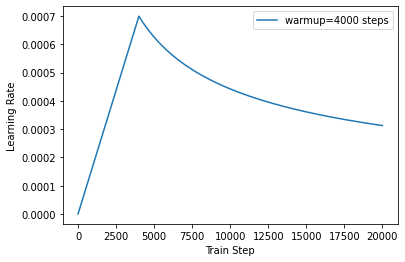

In [ ]:
# 测试
import warnings
warnings.filterwarnings("ignore")

n_layers, d_model, n_heads, d_ff  = 6, 512, 1, 2048

src_vocab_size = len(SRC_TEXT.vocab) 
tgt_vocab_size = len(TGT_TEXT.vocab) 

d_k = d_v = d_model // n_heads

model = Transformer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9)
learning_rate = CustomSchedule(optimizer, warm_steps=4000)


lr_list = []
for i in range(1, 20000):
    learning_rate.step()
    lr_list.append(learning_rate.get_lr()[0])
plt.figure()
plt.plot(np.arange(1, 20000), lr_list)
plt.legend(['warmup=4000 steps'])
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
plt.show()

In [ ]:
def train_step(inp,tgt,criterion):
    # 采取teacher_forcing，将上一个时间步的标签直接输入模型
    tgt_input = tgt[:,:-1]
    tgt_real = tgt[:,1:]

    # to(device)不能少，否则默认cpu
    inp = inp.to(device)
    tgt_input = tgt_input.to(device)
    tgt_real = tgt_real.to(device)

    model.train()
    optimizer.zero_grad()

    # pred ==> [bz, seq_len, vocab_size]
    # tgt_real ==> [bz, seq_len]
    pred, enc_self_attns, dec_self_attns, dec_enc_attns = model(inp, tgt_input)
    # pdb.set_trace()
    # transformed_pred ==> [bz x seq_len, vocab_size]
    # transformed_tgt_real ==> [bz x seq_len, ]
    loss = criterion(pred.view(-1, pred.size(-1)), tgt_real.contiguous().view(-1))
    # sum()不能忘，item()只能转换标量值为python值而非向量
    loss_ = loss.sum().item()

    # pred_ ==> [bz, seq_len]
    pred_ = pred.argmax(dim=-1)
    acc = pred_.eq(tgt_real)
    # acc计算比例需要算占总比多少
    # 画图时必须要item()
    acc = (acc.sum()/ tgt.size(0)/ tgt.size(1)).item()

    loss.backward()
    optimizer.step()

    return loss_, acc 

In [ ]:
# 检查train_step()的效果
criterion = nn.CrossEntropyLoss()
batch_src, batch_tgt = next(iter(train_dataloader))
train_step(batch_src, batch_tgt, criterion)
# print(tgt_input.shape)
# tgt_input = batch_tgt[:,:-1]
# tgt_real = batch_tgt[:,1:]
# print(tgt_input.shape)
# print(tgt_real.shape)


(7.867550849914551, 0.0013020833721384406)

In [ ]:
def validation_step(inp, tgt, criterion):
    tgt_input = tgt[:,:-1]
    tgt_real = tgt[:,1:]

    inp = inp.to(device)
    tgt_input = tgt_input.to(device)
    tgt_real = tgt_real.to(device)

    model.eval()

    with torch.no_grad():
        pred, _, _, _ = model(inp, tgt_input)
        val_loss = criterion(pred.view(-1, pred.size(-1)), tgt_real.contiguous().view(-1))
        val_loss = val_loss.sum().item()

        pred_ = pred.argmax(dim=-1)
        val_acc = pred_.eq(tgt_real)
        val_acc = (val_acc.sum()/ tgt.size(0)/ tgt.size(1)).item()
    return val_loss, val_acc


In [ ]:
EPOCHS = 20

print_trainstep_every = 50

lr_scheduler = CustomSchedule(optimizer, warm_steps=4000)

# 存储数据
df_history = pd.DataFrame(columns=["epoch","loss","acc","val_loss","val_acc"])

# 打印时间
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m_%d %H:%M:%S')
    print('\n' + "=========="*4 + '%s'%nowtime + "=========="*4)

In [ ]:
printbar()


========================================2021-06_08 14:41:16========================================


In [ ]:
save_dir = "train"
def train_model(epochs, train_dataloader, val_dataloader, print_every):
    starttime = time.time()
    print('\n' + "=========="*4 + "start training" + "=========="*4)
    best_acc = 0.8 
    # best_acc = 0.7 # 长句子
    for epoch in range(1, epochs + 1):

        loss_sum = 0
        acc_sum = 0

        for step, (inp, tgt) in enumerate(train_dataloader, start=1):
            loss, acc = train_step(inp, tgt, criterion)
            loss_sum += loss
            acc_sum += acc 

            # 打印batch级别信息
            if step % print_every == 0:
                print('*' * 8, f'[step = {step}] loss: {loss_sum / step:.3f}, {"acc"}: {acc_sum / step:.3f}')
            
            # 更新学习率
            lr_scheduler.step()
        # 一个epoch结束，做一次验证
        val_loss_sum = 0
        val_acc_sum = 0
        for val_step, (inp, tgt) in enumerate(val_dataloader, start=1):
            val_loss, val_acc = validation_step(inp, tgt, criterion)
            val_loss_sum += val_loss
            val_acc_sum += val_acc 
        
        # 记录收集一个epoch的信息
        # 与列对应
        # epoch从0开始
        record = (epoch, loss_sum/step, acc_sum/step, val_loss_sum/val_step, val_acc_sum/val_step) 
        df_history.loc[epoch-1] = record
        # 打印epoch级别的日志
        print('EPOCH = {} loss: {:.3f}, {}: {:.3f}, val_loss: {:.3f}, val_{}: {:.3f}'.format(
        record[0], record[1], "acc", record[2], record[3], "acc", record[4]))
        printbar()
        current_acc_avg = val_acc_sum / val_step 
        # 若大于基础正确率，则保存
        if current_acc_avg > best_acc:
            best_acc = current_acc_avg
            checkpoint = save_dir + '{:03d}_{:.2f}_ckpt.tar'.format(epoch, current_acc_avg)
            
            # 若只是普通保存，则只会保留基础网络结构而非具体参数
            model_sd = copy.deepcopy(model.state_dict())
            torch.save({
                'loss': loss_sum / step,
                'epoch': epoch,
                'net': model_sd,
                'opt': optimizer.state_dict(),
                'lr_scheduler': lr_scheduler.state_dict()
            }, checkpoint)
        print('finishing training...')
    
    # 时间记录
    endtime = time.time()
    time_elapsed = endtime - starttime
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    return df_history

In [ ]:
# 开始训练
df_history = train_model(EPOCHS, train_dataloader, val_dataloader, print_trainstep_every)
print(df_history)


========================================start training========================================
******** [step = 50] loss: 4.520, acc: 0.351
******** [step = 100] loss: 3.758, acc: 0.456
EPOCH = 1 loss: 3.417, acc: 0.498, val_loss: 2.210, val_acc: 0.648

========================================2021-06_08 14:41:28========================================
finishing training...
******** [step = 50] loss: 2.031, acc: 0.659
******** [step = 100] loss: 1.924, acc: 0.668
EPOCH = 2 loss: 1.874, acc: 0.672, val_loss: 1.680, val_acc: 0.690

========================================2021-06_08 14:41:41========================================
finishing training...
******** [step = 50] loss: 1.563, acc: 0.699
******** [step = 100] loss: 1.510, acc: 0.705
EPOCH = 3 loss: 1.479, acc: 0.708, val_loss: 1.360, val_acc: 0.723

========================================2021-06_08 14:41:54========================================
finishing training...
******** [step = 50] loss: 1.274, acc: 0.727
******** [step =

In [ ]:
def plot_metric(df_history, metric):
    plt.figure()

    train_metrics = df_history[metric]
    val_metrics = df_history["val_" + metric]

    # epochs变为列表，才能画
    epochs = range(1, len(train_metrics) + 1)

    plt.plot(epochs, train_metrics, "bo--")
    plt.plot(epochs, val_metrics, "ro--")

    plt.title("Training and validation " + metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_" + metric,"val_" + metric])
    plt.savefig(metric + " conv" + ".png")
    plt.show()

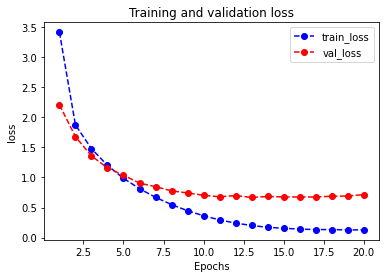

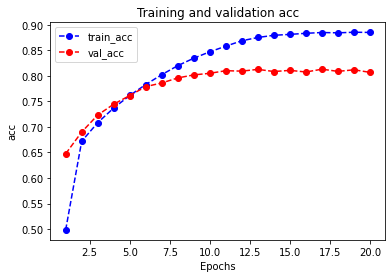

In [ ]:
plot_metric(df_history, "loss")
plot_metric(df_history, "acc")

In [ ]:
# 具体看保存哪个，需要自行修改
checkpoint = "/content/train017_0.81_ckpt.tar"
print("checkpoint:",checkpoint)

ckpt = torch.load(checkpoint)

transformer_sd = ckpt["net"]

reload_model = Transformer().to(device)
reload_model.load_state_dict(transformer_sd)


checkpoint: /content/train017_0.81_ckpt.tar


<All keys matched successfully>

In [ ]:
def tokenizer_encode(tokenize, sentence, vocab):
    sentence = normalizeString(sentence)

    sentence = tokenize(sentence)
    sentence = ["<start>"] + sentence + ["<end>"]
    sentence_ids = [vocab.stoi[token] for token in sentence]
    return sentence_ids

def tokenizer_decode(sentence_ids, vocab):
    sentence = [vocab.itos[id] for id in sentence_ids if id < len(vocab)]
    return " ".join(sentence)

In [ ]:
# 只有一个句子，不需要加pad
s = 'je pars en vacances pour quelques jours .'
print(tokenizer_encode(tokenizer, s, SRC_TEXT.vocab))


s_ids = [3, 5, 251, 17, 365, 35, 492, 390, 4, 2]
print(tokenizer_decode(s_ids, SRC_TEXT.vocab))
print(tokenizer_decode(s_ids, TGT_TEXT.vocab))

[3, 5, 251, 17, 365, 35, 492, 390, 4, 2]
<start> je pars en vacances pour quelques jours . <end>
<start> i tennis very forgetful me helping bed . <end>


In [ ]:
def evaluate(inp_sentence):
    reload_model.eval()
    
    inp_sentence_ids = tokenizer_encode(tokenizer, inp_sentence, SRC_TEXT.vocab)
    # =>[b=1, inp_seq_len=10]
    encoder_input = torch.tensor(inp_sentence_ids).unsqueeze(dim=0)

    # 预估时一句对一句，decode_input为<start>
    decoder_input = [TGT_TEXT.vocab.stoi["<start>"]]
    # =>[b=1, inp_seq_len=1]    
    decoder_input = torch.tensor(decoder_input).unsqueeze(0)

    encoder_input = encoder_input.to(device)
    decoder_input = decoder_input.to(device)

    with torch.no_grad():
        for i in range(MAX_LENGTH + 2):
            # pred ==> [b=1, 1(len_q), tgt_vocab_size]
            pred, enc_self_attns, dec_self_attns, dec_enc_attns = reload_model(encoder_input, decoder_input)
            # 最后一个词
            # pdb.set_trace()
            pred = pred[:,-1:,:]
            # pred_ids ==> [1,1]
            pred_ids = torch.argmax(pred, dim=-1)

            if pred_ids.squeeze().item() == TGT_TEXT.vocab.stoi["<end>"]:
              return decoder_input.squeeze(dim=0), dec_enc_attns
            
            # [b=1, tgt_seq_len=1] ==> [b=1, tgt_seq_len=2]
            # deocder_input不断变长
            decoder_input = torch.cat([decoder_input, pred_ids],dim=-1)
    return decoder_input.squeeze(dim=0), dec_enc_attns

In [ ]:
s = 'je pars en vacances pour quelques jours .'
s_targ = 'i m taking a couple of days off .'
pred_result, attention_weights = evaluate(s)
pred_sentence = tokenizer_decode(pred_result, TGT_TEXT.vocab)
print('real target:', s_targ)
print('pred_sentence:', pred_sentence)

real target: i m taking a couple of days off .
pred_sentence: <start> i m taking a couple of days off .


In [ ]:
# 为长句子准备
sentence_pairs = [
    ['ce n est pas un chat . c est un chien .', 'that s not a cat . it s a dog .'],
    ['je m en fiche s il fait un peu froid .', 'i don t care if it s a bit cold .'],
    ['bientot ce ne sera plus inedit de vivre jusqu a cent cinquante ans .', 'soon it won t be unheard of to live to .'],
]
def batch_translate(sentence_pairs):
    for pair in sentence_pairs:
        print('input:', pair[0])
        print('target:', pair[1])
        pred_result, _ = evaluate(pair[0])
        pred_sentence = tokenizer_decode(pred_result, TGT_TEXT.vocab)
        print('pred:', pred_sentence)
        print('')

batch_translate(sentence_pairs)

input: ce n est pas un chat . c est un chien .
target: that s not a cat . it s a dog .
pred: <start> he s not a professional .

input: je m en fiche s il fait un peu froid .
target: i don t care if it s a bit cold .
pred: <start> i m just starting a bit cold .

input: bientot ce ne sera plus inedit de vivre jusqu a cent cinquante ans .
target: soon it won t be unheard of to live to .
pred: <start> we re not going to make a host .



In [ ]:
# 批量翻译
sentence_pairs = [
    ['je pars en vacances pour quelques jours .', 'i m taking a couple of days off .'],
    ['je ne me panique pas .', 'i m not panicking .'],
    ['je recherche un assistant .', 'i am looking for an assistant .'],
    ['je suis loin de chez moi .', 'i m a long way from home .'],
    ['vous etes en retard .', 'you re very late .'],
    ['j ai soif .', 'i am thirsty .'],
    ['je suis fou de vous .', 'i m crazy about you .'],
    ['vous etes vilain .', 'you are naughty .'],
    ['il est vieux et laid .', 'he s old and ugly .'],
    ['je suis terrifiee .', 'i m terrified .'],
]


def batch_translate(sentence_pairs):
    for pair in sentence_pairs:
        print('input:', pair[0])
        print('target:', pair[1])
        pred_result, _ = evaluate(pair[0])
        pred_sentence = tokenizer_decode(pred_result, TGT_TEXT.vocab)
        print('pred:', pred_sentence)
        print('')

batch_translate(sentence_pairs)

input: je pars en vacances pour quelques jours .
target: i m taking a couple of days off .
pred: <start> i m taking a couple of days off .

input: je ne me panique pas .
target: i m not panicking .
pred: <start> i m not panicking .

input: je recherche un assistant .
target: i am looking for an assistant .
pred: <start> i am looking for an assistant .

input: je suis loin de chez moi .
target: i m a long way from home .
pred: <start> i m a long way home .

input: vous etes en retard .
target: you re very late .
pred: <start> you re late .

input: j ai soif .
target: i am thirsty .
pred: <start> i m thirsty .

input: je suis fou de vous .
target: i m crazy about you .
pred: <start> i m crazy about you .

input: vous etes vilain .
target: you are naughty .
pred: <start> you are naughty .

input: il est vieux et laid .
target: he s old and ugly .
pred: <start> he s old and ugly .

input: je suis terrifiee .
target: i m terrified .
pred: <start> i m terrified .



input: je pars en vacances pour quelques jours .
target: i m taking a couple of days off .
pred: <start> i m taking a couple of days off .



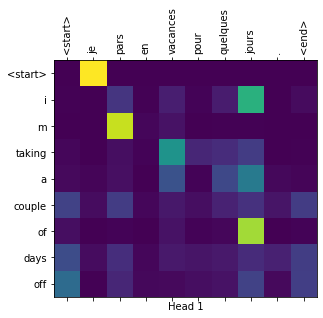

input: je recherche un assistant .
target: i am looking for an assistant .
pred: <start> i am looking for an assistant .



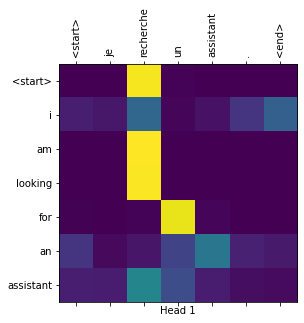

In [ ]:
# 可视化attenton 这里我们只展示...block2的attention，即[b, num_heads, tgt_seq_len, inp_seq_len]
# attention: {'decoder_layer{i + 1}_block1': [b, num_heads, tgt_seq_len, tgt_seq_len],
#             'decoder_layer{i + 1}_block2': [b, num_heads, tgt_seq_len, inp_seq_len], ...}
# sentence: [seq_len]，例如：'je recherche un assistant .'
# pred_result: [seq_len]，例如：'<start> i m looking for an assistant .'
# layer: 表示模型decoder的N层decoder-layer的第几层的attention，形如'decoder_layer{i}_block1'或'decoder_layer{i}_block2'
def plot_attention_weights(attention, sentence, pred_sentence, layer):
    sentence = sentence.split()
    pred_sentence = pred_sentence.split()
    # pdb.set_trace()
    fig = plt.figure(figsize=(16, 8))

    # block2 attention[layer] => [b=1, num_heads, targ_seq_len, inp_seq_len]
    # attention为列表，长度为层数6
    attention = torch.squeeze(attention[layer], dim=0) # => [num_heads, targ_seq_len, inp_seq_len]

    for head in range(attention.shape[0]):
        # 111是单个整数编码的子绘图网格参数。例如，“111”表示“1×1网格，第一子图”，“234”表示“2×3网格，第四子图”

        ax = fig.add_subplot(2, 4, head + 1)  
        cax = ax.matshow(attention[head].cpu(), cmap='viridis')  # 绘制网格热图，注意力权重
        # fig.colorbar(cax)#给子图添加colorbar（颜色条或渐变色条）

        fontdict = {'fontsize': 10}

        # 设置轴刻度线
        ax.set_xticks(range(len(sentence)+2))  # 算上start和end
        ax.set_yticks(range(len(pred_sentence)))

        ax.set_ylim(len(pred_sentence) - 1.5, -0.5)  # 设定y座标轴的范围

        # 设置轴
        ax.set_xticklabels(['<start>']+sentence+['<end>'], fontdict=fontdict, rotation=90)  # 顺时间旋转90度
        ax.set_yticklabels(pred_sentence, fontdict=fontdict)

        ax.set_xlabel('Head {}'.format(head + 1))
    plt.tight_layout()
    plt.show()


def translate(sentence_pair, plot=None):
    print('input:', sentence_pair[0])
    print('target:', sentence_pair[1])
    pred_result, attention_weights = evaluate(sentence_pair[0])
    # print('attention_weights:', attention_weights[0])
    # pdb.set_trace()
    pred_sentence = tokenizer_decode(pred_result, TGT_TEXT.vocab)
    print('pred:', pred_sentence)
    print('')

    if plot:
        plot_attention_weights(attention_weights, sentence_pair[0], pred_sentence, plot)


translate(sentence_pairs[0], plot=1)

translate(sentence_pairs[2], plot=2)
